# Model Prototype

### This notebook shows how to create a baseline model pipeline and save it

##### We save the Spark Dataframe as an Iceberg Table. Iceberg is a new open table format backed by Apple, Netflix and Cloudera. 
##### In the context of ML Ops, the most anticipated feature is Time Travel i.e. the ability to reproduce the data and the schema across different versions in time
##### Finally, we create a simple PySpark pipeline and train a classifier with Keras/Tensorflow

* For a more comprehensive demo of Iceberg in CML, please visit the [Spark3 Iceberg CML Github Repository](https://github.com/pdefusco/Spark3_Iceberg_CML)
* For a more detailed introduction to CML Session, Notebooks, and Spark tips and trips please visit the [CML Total Beginner GitHub Repository](https://github.com/pdefusco/CML-Total-Beginner)
* For a more comprehensive example of the Atlas Python client mentioned below, please visit the [Atlas Client Example Notebook in the Data Integration with ML GitHub Repository](https://github.com/pdefusco/Data_Integration_wMachineLearning/blob/main/2_A_Atlas_Client_Example.ipynb)

In [8]:
#spark.stop()

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import IntegerType, FloatType

#### The Spark Session is created with the following configurations. If you get an error, ensure your CML Session is using Runtimes and Spark 3.1.

In [2]:
spark = SparkSession.builder\
  .appName("0.1 - Model Prototype") \
  .config("spark.kerberos.access.hadoopFileSystems", os.environ["STORAGE"])\
  .getOrCreate()
  #.config("spark.jars","/home/cdsw/lib/iceberg-spark3-runtime-0.9.1.1.13.317211.0-9.jar") \
  #.config("spark.sql.extensions","org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
  #.config("spark.sql.catalog.spark_catalog","org.apache.iceberg.spark.SparkSessionCatalog") \
  #.config("spark.sql.catalog.spark_catalog.type","hive") \

Setting spark.hadoop.yarn.resourcemanager.principal to pauldefusco


#### Loading the data...

In [3]:
# Load and parse the data file, converting it to a DataFrame.
df = spark.read.csv(os.environ["STORAGE"]+'/datalake/model_factory/LoanStats_2015_subset_091322.csv',   
    header=True,
    sep=',',
    nullValue='NA')

In [4]:
df.count()

111073

#### Investigating Target Class Imbalance

In [5]:
df.select("loan_status").distinct().show()

+------------------+
|       loan_status|
+------------------+
|        Fully Paid|
|           Default|
|   In Grace Period|
|       Charged Off|
|Late (31-120 days)|
|           Current|
| Late (16-30 days)|
|             10500|
+------------------+



In [6]:
#Types of loan status
print(df.groupBy('loan_status').count().show())

+------------------+-----+
|       loan_status|count|
+------------------+-----+
|        Fully Paid|42826|
|           Default|    3|
|   In Grace Period|  813|
|       Charged Off|15053|
|Late (31-120 days)| 1519|
|           Current|50516|
| Late (16-30 days)|  342|
|             10500|    1|
+------------------+-----+

None


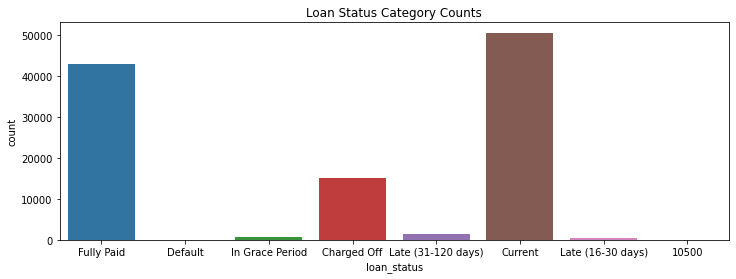

In [7]:
df_plot = df.groupBy('loan_status').count().toPandas()
plt.figure(figsize=(12,4))
g = sns.barplot(x="loan_status", y="count", data=df_plot)
g.set_title('Loan Status Category Counts')
plt.show()

#### Creating the Target Feature

In [8]:
df = df.withColumn("label", when((df["loan_status"] == "Charged Off")|(df["loan_status"] == "Default"), 1).otherwise(0))

We want to predict Default vs Non-Default Loan Applicants...

In [9]:
df = df.withColumn("acc_now_delinq", df["acc_now_delinq"].cast(FloatType()))
df = df.withColumn("acc_open_past_24mths", df["acc_open_past_24mths"].cast(FloatType()))
df = df.withColumn("annual_inc", df["annual_inc"].cast(FloatType()))
df = df.withColumn("avg_cur_bal", df["avg_cur_bal"].cast(FloatType()))
df = df.withColumn("funded_amnt", df["funded_amnt"].cast(FloatType()))

In [10]:
df = df.select(['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'avg_cur_bal', 'funded_amnt', 'label'])
#df = df.dropna()

In [11]:
df = df.na.drop(subset=["addr_state"])

In [12]:
li=["TX","CA","FL", "CO"]
df = df.filter(df.addr_state.isin(li))

In [13]:
df = df.limit(10000)

In [14]:
df = df.fillna(0)

In [15]:
df.dtypes

[('acc_now_delinq', 'float'),
 ('acc_open_past_24mths', 'float'),
 ('addr_state', 'string'),
 ('annual_inc', 'float'),
 ('avg_cur_bal', 'float'),
 ('funded_amnt', 'float'),
 ('label', 'int')]

In [16]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+--------------+--------------------+----------+----------+-----------+-----------+-----+
|acc_now_delinq|acc_open_past_24mths|addr_state|annual_inc|avg_cur_bal|funded_amnt|label|
+--------------+--------------------+----------+----------+-----------+-----------+-----+
|             0|                   0|         0|         0|          0|          0|    0|
+--------------+--------------------+----------+----------+-----------+-----------+-----+



We start with a baseline...  we decide to start with only a few key features.

#### Let's create a simple Baseline Model Pipeline

In [17]:
train = df.sampleBy("label", fractions={0: 0.8, 1: 0.8}, seed=10)

In [18]:
test = df.subtract(train)

In [45]:
train.cache()
test.cache()

DataFrame[acc_now_delinq: float, acc_open_past_24mths: float, addr_state: string, annual_inc: float, avg_cur_bal: float, funded_amnt: float, label: int]

In [46]:
train.dtypes

[('acc_now_delinq', 'float'),
 ('acc_open_past_24mths', 'float'),
 ('addr_state', 'string'),
 ('annual_inc', 'float'),
 ('avg_cur_bal', 'float'),
 ('funded_amnt', 'float'),
 ('label', 'int')]

In [47]:
import random
import numpy as np
from pyspark.sql import Row
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F

In [85]:
#Creating list of categorical and numeric features
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df.dtypes if item[1].startswith('in') or item[1].startswith('dou') or item[1].startswith('floa')]
cols = cat_cols + num_cols

In [86]:
num_cols

['acc_now_delinq',
 'acc_open_past_24mths',
 'annual_inc',
 'avg_cur_bal',
 'funded_amnt',
 'label']

In [87]:
#Creates a Pipeline Object including One Hot Encoding of Categorical Features  
def make_pipeline(spark_df):   
    
    spark_df = spark_df.dropna()
    
    #Creating list of categorical and numeric features
    cat_cols = [item[0] for item in spark_df.dtypes if item[1].startswith('string')]
    num_cols = [item[0] for item in spark_df.dtypes if item[1].startswith('in') or item[1].startswith('dou')]
    cols = cat_cols + num_cols
    
    stages= []
        
    addr_state_stringIndexer = StringIndexer(inputCol = "addr_state" , outputCol = "addr_state" + '_StringIndex').setHandleInvalid("keep")
    stages += [addr_state_stringIndexer]
    
    #for indexer in stages:
    #    indexer.setHandleInvalid("keep")
    
    encoder = OneHotEncoder(inputCols=[col + '_StringIndex' for col in cat_cols], outputCols=[col + '_ClassVect' for col in cat_cols], dropLast=True, handleInvalid="keep")
    stages += [encoder]

    #Assembling mixed data type transformations:
    assemblerInputs = [c + "_ClassVect" for c in cat_cols] + num_cols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features").setHandleInvalid("keep")
    stages += [assembler]
    
    #Assembling mixed data type transformations:
    #assembler = VectorAssembler(inputCols=cols, outputCol="features").setHandleInvalid("skip")
    #stages += [assembler]    
    
    #Scaling features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    stages += [scaler]
    
    #Logistic Regression
    lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=100, regParam=0.0001, elasticNetParam=0.0001)
    stages += [lr]
    
    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)

    return pipelineModel

In [88]:
pipelineModel = make_pipeline(train)

In [89]:
clf_out_df = pipelineModel.transform(test)

In [90]:
clf_pd = clf_out_df.toPandas()

In [91]:
clf_pd.shape

(1989, 14)

In [92]:
clf_pd[['label', 'prediction']].groupby('label').count()

,prediction
label,
0,1691
1,298


In [93]:
clf_pd[['label', 'prediction']].groupby('prediction').count()

,label
prediction,
0.0,1691
1.0,298


In [94]:
clf_out_df.select("label", "prediction").groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0|  298|
|       0.0| 1691|
+----------+-----+



In [95]:
clf_out_df.select("label", "prediction").groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  298|
|    0| 1691|
+-----+-----+



In [96]:
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = pipelineModel.stages[-1].summary

In [97]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

objectiveHistory:
0.4173343463002625
0.26991615513652284
0.1094530587557542
0.07606956823758919
0.04922902309465106
0.03251417987287885
0.02164536502598171
0.014575015870518335
0.009953843036456154
0.006937242588871075
0.004977890345023744
0.0037179603806391367
0.002920942464617634
0.0024287756415779377
0.0021352351571996974
0.0018675820180907518
0.0018129791429904157
0.0018020974131883628
0.001801401339148158
0.0018012462622336066
0.0018012210819097366
0.0018012178890010361
0.001801217867051687


In [98]:
def plot_roc(model):
    
    plt.figure(figsize=(5,5))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(model.summary.roc.select('FPR').collect(),
             model.summary.roc.select('TPR').collect())
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


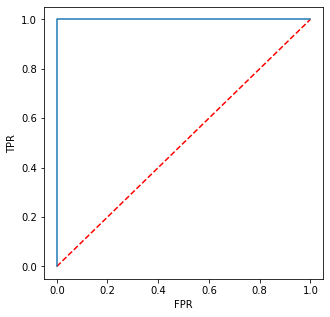

In [99]:
plot_roc(pipelineModel.stages[-1])

In [100]:
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 1.0
FPR: 0.0
TPR: 1.0
F-measure: 1.0
Precision: 1.0
Recall: 1.0


#### Time to train the classifier on the original data and deploy our scoring pipeline with CML Jobs

In [101]:
def score_data(df):
    
    #Scoring on the entire dataset now
    #df = cols_to_float(df)
    pipelineModel = make_pipeline(df)
    scored_df = pipelineModel.transform(df)
    scored_df = scored_df.select("acc_now_delinq", "acc_open_past_24mths", "annual_inc", "avg_cur_bal", "funded_amnt", "label")

    return scored_df, pipelineModel

In [102]:
scored_df, pipelineModel = score_data(df)

In [103]:
#This is a sample of what we will save to the datawarehouse
scored_df.show(4)

+--------------+--------------------+----------+-----------+-----------+-----+
|acc_now_delinq|acc_open_past_24mths|annual_inc|avg_cur_bal|funded_amnt|label|
+--------------+--------------------+----------+-----------+-----------+-----+
|           0.0|                 6.0|   50050.0|      809.0|     8000.0|    1|
|           0.0|                 1.0|   80000.0|     3393.0|    20000.0|    1|
|           0.0|                 7.0|  183000.0|    19827.0|    21000.0|    0|
|           0.0|                 4.0|   70000.0|      613.0|     9050.0|    0|
+--------------+--------------------+----------+-----------+-----------+-----+
only showing top 4 rows



#### Convert Model to ONNX

In [104]:
import onnxruntime
import onnxmltools
import onnx
from onnxmltools.convert.common.data_types import FloatTensorType, StringTensorType, Int8TensorType
from onnxmltools.convert.sparkml.utils import buildInitialTypesSimple

In [105]:
onnx_df = df.drop('label')

In [106]:
initial_types = onnxmltools.convert.sparkml.buildInitialTypesSimple(onnx_df)

In [107]:
initial_types

[('acc_now_delinq', FloatTensorType(shape=[1, 1])),
 ('acc_open_past_24mths', FloatTensorType(shape=[1, 1])),
 ('addr_state', StringTensorType(shape=[1, 1])),
 ('annual_inc', FloatTensorType(shape=[1, 1])),
 ('avg_cur_bal', FloatTensorType(shape=[1, 1])),
 ('funded_amnt', FloatTensorType(shape=[1, 1]))]

In [108]:
onnx_model = onnxmltools.convert.convert_sparkml(pipelineModel, 'My Sparkml Pipeline', initial_types)

AttributeError: 'NoneType' object has no attribute 'shape'

In [109]:
with open("../models/model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

NameError: name 'onnx_model' is not defined

In [115]:
#spark.stop()

#### We will store the classifier locally but we could also use other storage options (S3, ADLS, GCS, HDFS, Ozone, etc.)

In [81]:
#def save_local_clf(clf_pipeline):
#    clf_pipeline.write().save("/home/cdsw/models")

#def save_s3_clf(clf_pipeline):
    #Saving pipeline to S3:
#    clf_pipeline.write().save(os.environ["STORAGE"]+"/datalake/pdefusco/pipeline")

In [83]:
#df = cols_to_float(df)

In [84]:
#def save_s3_data(df):
#    df.write.mode("overwrite").option("header", "true").parquet(os.environ["STORAGE"]+"/datalake/pdefusco/LoanStats_2015_subset.parquet") 
    
#df = spark.read.parquet('s3a://demo-aws-go02/datalake/pdefusco/LoanStats_2015_subset.parquet',   
#    header=True,
#    sep=',',
#    nullValue='NA')

In [114]:
#save_s3_data(df)